In [1]:
import os
from functools import partial

import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Activation, Input, Dropout, BatchNormalization, Conv1D, MaxPooling1D, GlobalAveragePooling1D
from keras.models import Model, Sequential
from keras.utils.np_utils import to_categorical
import keras.backend as K
import tensorflow as tf

%matplotlib inline

Using TensorFlow backend.


In [2]:
%cd challenger.ai/stock/data

dt = "20171103"

[Errno 2] No such file or directory: 'challenger.ai/stock/data'
/home/kissg/Developing/comp/challenger.ai/stock/data


In [3]:
train_data = pd.read_csv(
    os.path.join(dt,
                 "ai_challenger_stock_train_{dt}".format(dt=dt),
                 "stock_train_data_{dt}.csv".format(dt=dt)))
fnames = ["feature{i}".format(i=i) for i in range(88)]
fnames_group = fnames + ["group"]

In [5]:
test_data = pd.read_csv(os.path.join(dt,
                 "ai_challenger_stock_test_{dt}".format(dt=dt),
                 "stock_test_data_{dt}.csv".format(dt=dt)))

In [11]:
np.unique(train_data.loc[:, "code_id"]).shape

(2463,)

In [12]:
np.unique(train_data.loc[:, "group1"]).shape

(28,)

In [13]:
np.unique(train_data.loc[:, "group2"]).shape

(102,)

In [14]:
def eliminate_outliers(train_data):
    features = train_data[fnames]
    features_desc = features.describe(percentiles=[0.0001, 0.9999])
    
    # 比较粗糙地定义上下界: 对每一个特征都限定了上下界.
    # 实际上没有 outlier 的话, 不必为特征定义上下界
    lbound = features_desc.loc["0.01%"]  # lower bound, 1-D 数组, 记录每个特征的 0.01% 的值
    ubound = features_desc.loc["99.99%"]

    # np.argmax(features["feature3"])  # 求 feature3 对应的索引, 24816
    lt_ubound = features.le(ubound.as_matrix().transpose())  # less than upper bound, 此处确实按列进行比较, 亲测
    train_data_ulimited = train_data.loc[lt_ubound.all(axis=1)]  # 仅保留所有特征不含异常值的样本
    gt_lbound = features.ge(lbound.as_matrix().transpose())
    train_data_llimited = train_data.loc[gt_lbound.all(axis=1)]
    
    sample_ids = np.intersect1d(train_data_ulimited.id.values, train_data_llimited.id.values)
    train_data_limited = train_data[train_data.id.isin(sample_ids)]  # 2.56 s +- 42.3 ms
    
    # 此处用 merge 求交
    # train_data_limited = pd.merge(train_data_ulimited, train_data_llimited)  # 51.7 s +- 2.5 s 
    
    return train_data_limited

In [15]:
train_data_limited = eliminate_outliers(train_data)

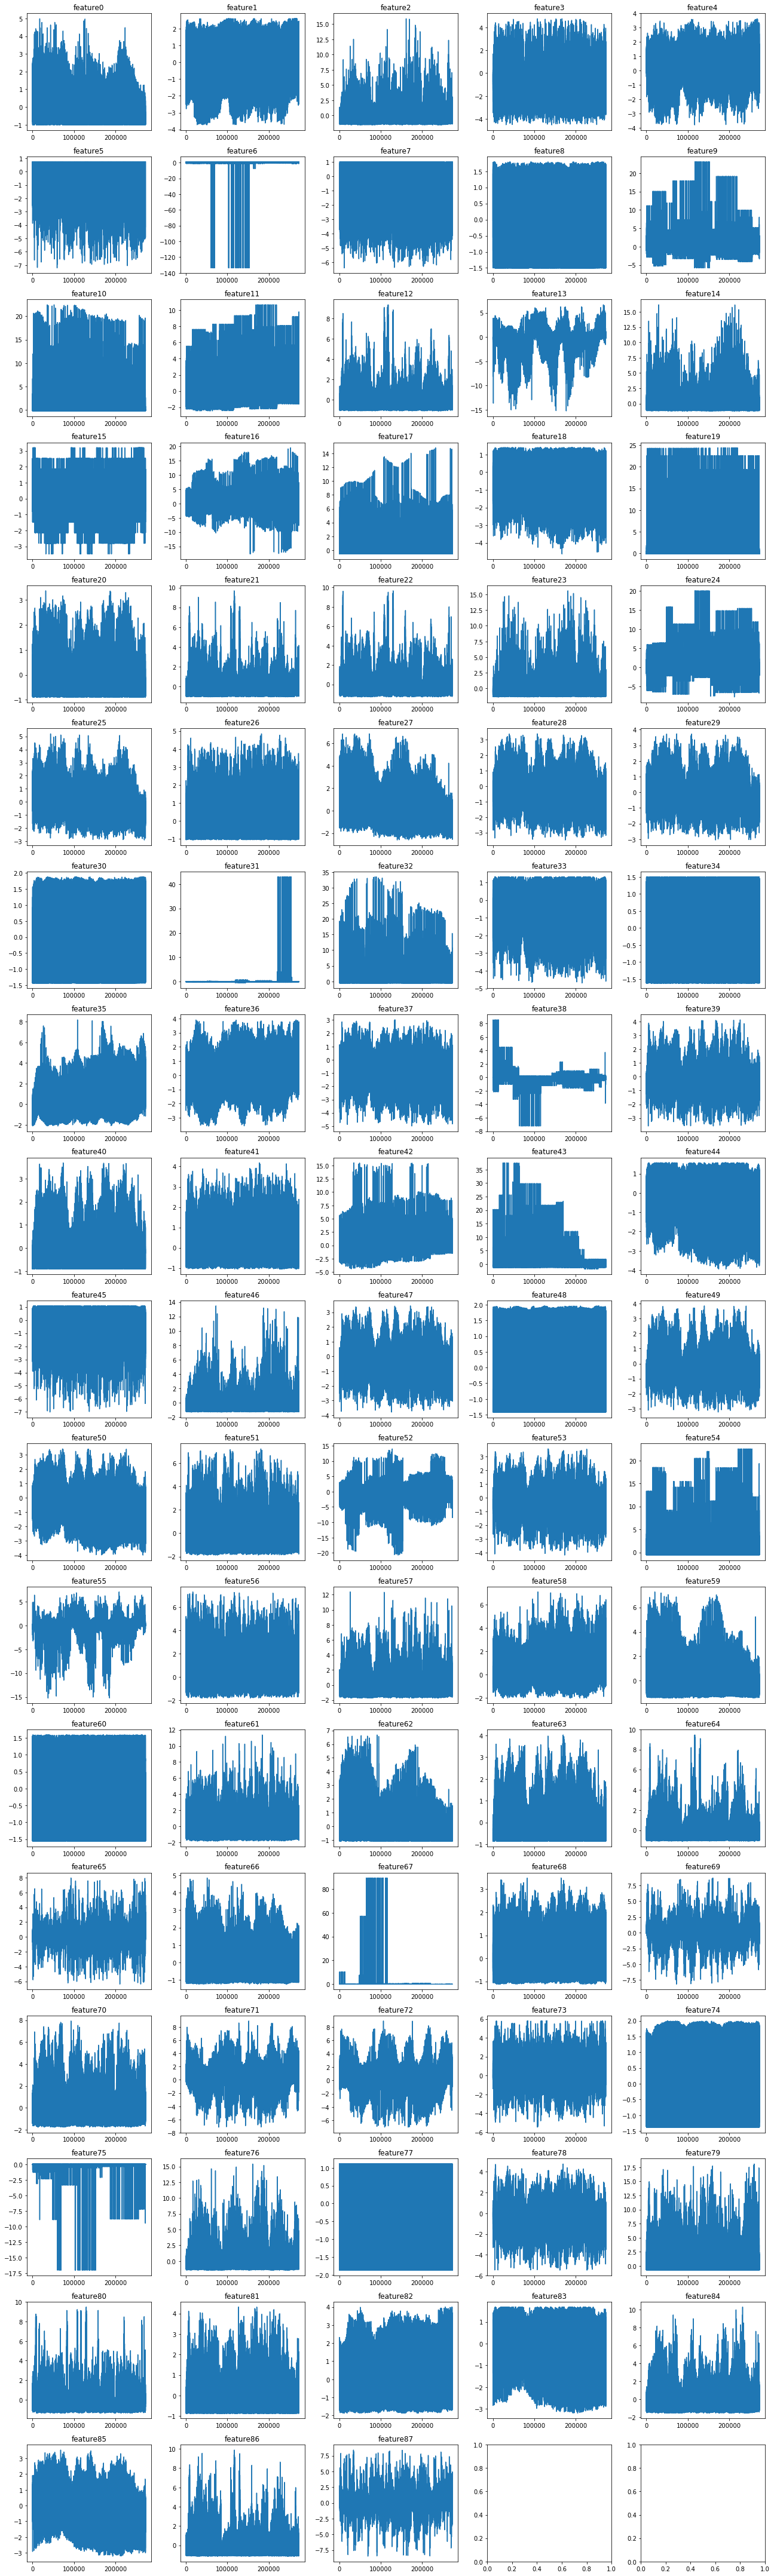

In [16]:
figsize(18, 60)

f, arr = plt.subplots(nrows=18, ncols=5)
for i in range(0, 88):
    a, b = divmod(i, 5)
    feat = train_data_limited["feature{i}".format(i=i)].values
    arr[a, b].plot(np.arange(feat.shape[0]), feat)
    arr[a, b].set_title("feature{i}".format(i=i))

plt.tight_layout()
plt.show()

In [14]:
train_data.head()

,id,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,...,feature82,feature83,feature84,feature85,feature86,feature87,weight,label,group,era
0,0,-0.416761,-0.211610,0.411033,-0.908502,-0.562977,-0.499883,-1.369509,-1.204130,0.006665,...,-0.432287,-0.711905,-0.914836,-1.596061,-1.614297,-0.997881,1.0,0.0,1,1
1,1,1.239197,-1.522371,0.949657,1.178559,0.113433,-0.384701,0.940446,3.127303,-0.569043,...,-0.234880,1.457955,0.045542,0.639762,0.657433,-0.009418,5.0,1.0,12,1
2,2,-0.757624,-0.414837,-0.585754,-1.091637,-2.547636,-0.439063,-0.935726,-0.927458,0.819233,...,1.041835,0.189340,-0.510791,-1.186198,-1.197839,-0.581987,4.0,1.0,8,1
3,3,1.178097,-0.615892,-0.752485,1.921163,0.875467,-0.458644,0.045608,0.078043,0.726521,...,0.627270,1.414313,0.237420,0.151403,0.161114,0.188158,5.0,1.0,6,1
4,4,0.056053,-0.688754,0.033647,-0.101820,-0.094364,-0.404475,-0.006384,-0.467311,-0.220231,...,-0.038220,0.437424,-0.477785,-0.204290,-0.200225,-0.153069,1.0,1.0,3,1


In [17]:
def train_dev_split(data, n=None):
    # split train and dev according to era
    # 函数用时: 120 ms +- 4 ms, 指定 n 的情况下可以快上 10 ms
    
    if not n:
        n = np.random.choice(np.unique(data["era"].values))

    is_specific_era = data["era"] == n
    # 从 train_dev 中划分出一部分加入训练集, 另一部分作为验证集.
    train_dev = data[is_specific_era]
    train_only = data[~is_specific_era]

    dev = train_dev.sample(train_dev.shape[0] // 3)  # train_dev 的 1/3 作为验证集, 总量的 1/60
    train_dev_train = train_dev[~train_dev["id"].isin(dev["id"])]
    train = train_only.append(train_dev_train)
    
    return train, dev

In [16]:
class myCallback(keras.callbacks.Callback):

    def on_batch_end(self, batch, logs={}):
        print(self.loss / self.sample_weight)

In [17]:
def logloss_t(y_true, y_pred):
    return -K.sum(K.multiply(y_true, K.log(y_pred)) + K.multiply((1 - y_true), K.log(1 - y_pred)))

In [18]:
def weighted_logloss_a(y_true, y_pred, weights):
    return -np.sum(np.multiply(
        weights.reshape(-1, 1),  
        (np.multiply(y_true, np.log(y_pred)) + np.multiply((1 - y_true), np.log(1 - y_pred))))) / np.sum(weights)

In [19]:
def kfold_cross_validate(k, epochs=100, nh=3, keep_prob=0.85, learning_rate=0.01, 
                         decay=1.0e-6, beta_1=0.98, beta_2=0.999, l1=0.001, l2=0.002):
    losses = []
    
    for i in range(k):
        # for comparision, random choose an era
        era = np.random.choice(np.arange(1, k + 1)) // 20
        train, dev = train_dev_split(train_data_limited, era)

        X_train, g_train, y_train, w_train = train[fnames].values, train["group"].values, train["label"].values.reshape(-1, 1), train["weight"].values
        X_dev, g_dev, y_dev, w_dev = dev[fnames].values, dev["group"].values, dev["label"].values.reshape(-1, 1), dev["weight"].values

        sc = StandardScaler()
        X_train_std = sc.fit_transform(X_train)
        X_dev_std = sc.transform(X_dev)
    
        # adam = keras.optimizers.adam(lr=learning_rate, decay=decay, beta_1=beta_1, beta_2=beta_2)
    
        # mdl = keras.models.clone_model(model)  # clone
        
        # mdl.compile(optimizer="adam",
        #         loss=keras.losses.binary_crossentropy,
        #         metrics=["binary_accuracy"])
        mdl = model_k1(nh=3, keep_prob=keep_prob, learning_rate=learning_rate, decay=decay, beta_1=beta_1, beta_2=beta_2, l1=l1, l2=l2)
        mdl.fit([X_train_std, g_train], y_train, batch_size=8096, epochs=epochs,
                validation_data=([X_dev_std, g_dev], y_dev),
                callbacks=[keras.callbacks.EarlyStopping(patience=5)],
                sample_weight=w_train.transpose())
        
        loss = weighted_logloss_a(y_dev, mdl.predict([X_dev_std, g_dev]), w_dev)
        losses.append(loss)
        
    return np.mean(losses)  # burn-in

In [36]:
def model_k1(nh=3, keep_prob=0.5, learning_rate=0.01, decay=0.00001, beta_1=0.999, beta_2=0.999, l1=0.0, l2=0.0):
    # 将 Label 直接视为概率的简单模型
    # 模型精度只比随机猜测好一点.
    
    # TODO: feature autoencoder
    features_input = Input(shape=(88, ), name="features_input")
    
    x = Dense(88, activation='tanh')(features_input)
    for i in range(nh - 1):
        x = Dense(max(2 ** (6-i), 32), activation="tanh")(x)
        x = BatchNormalization()(x)
        x = Dropout(keep_prob)(x)
        
    
    features_output = Dense(10, activation="tanh")(x)
    
    group_input = Input(shape=(28, ), name="group_input")

    x = keras.layers.concatenate([features_output, group_input])    
    # for i in range(nh - 1):
    #     x = Dense(max(2 ** (3-i), 8), activation="tanh")(x)
    #     # x = BatchNormalization()(x)
    #     x = Dropout(keep_prob)(x)
    
    output = Dense(1, activation='sigmoid', activity_regularizer=keras.regularizers.l1_l2(l1, l2), name='output')(x)

    adam = keras.optimizers.adam(lr=learning_rate, decay=decay, beta_1=beta_1, beta_2=beta_2)
    
    model = Model(inputs=[features_input, group_input], outputs=output)
    model.compile(optimizer=adam,
                loss=keras.losses.binary_crossentropy,
                 metrics=["binary_accuracy"])
    return model

In [ ]:
p = []
wlosses = []
for i in range(200):
    nh = np.random.choice([2, 3, 4])
    keep_prob = pow(10, -1 * np.random.rand())  # [0.1, 1]
    # learning_rate = pow(10, -3 * np.random.rand()) / 100  # [10 ** -5, 10 ** -2]
    # decay = pow(10, -3 * np.random.rand()) / 10000  # [10 ** -7, 10 ** -4]
    # beta_1 = 1 - pow(10, -2 * np.random.rand()) / 10  # [1 - 10 ** -1, 1 - 10 ** -3]
    # beta_2 = 1 - pow(10, -3 * np.random.rand()) / 100  # [1 - 10 ** -2, 1 - 10 ** -5]
    l1 = pow(10, -3 * np.random.rand()) / 1000  # [10 ** -6, 10 ** -3]
    l2 = pow(10, -3 * np.random.rand()) / 1000  # [10 ** -6, 10 ** -3]

    wloss = kfold_cross_validate(k=5, nh=nh, keep_prob=keep_prob, l1=l1, l2=l2)
    wlosses.append(wloss)
    p.append({"wloss": wloss, "nh": nh, "keep_prob": keep_prob, "l1": l1, "l2": l2})
             
print(wlosses)

Train on 382654 samples, validate on 6385 samples
Epoch 1/100
382654/382654 [==============================] - 2s - loss: 3.9469 - binary_accuracy: 0.5225 - val_loss: 0.7409 - val_binary_accuracy: 0.5176
Epoch 2/100
382654/382654 [==============================] - 1s - loss: 3.1454 - binary_accuracy: 0.5128 - val_loss: 0.7560 - val_binary_accuracy: 0.5076
Epoch 3/100
382654/382654 [==============================] - 1s - loss: 3.0780 - binary_accuracy: 0.5396 - val_loss: 0.7561 - val_binary_accuracy: 0.5142
Epoch 4/100
382654/382654 [==============================] - 1s - loss: 3.0485 - binary_accuracy: 0.5524 - val_loss: 0.7645 - val_binary_accuracy: 0.4985
Epoch 5/100
382654/382654 [==============================] - 1s - loss: 3.0132 - binary_accuracy: 0.5635 - val_loss: 0.7616 - val_binary_accuracy: 0.5234
Epoch 6/100
382654/382654 [==============================] - 1s - loss: 2.9803 - binary_accuracy: 0.5735 - val_loss: 0.7717 - val_binary_accuracy: 0.5186
Epoch 7/100
382654/382654 

382140/382140 [==============================] - 1s - loss: 2.7537 - binary_accuracy: 0.6175 - val_loss: 0.6558 - val_binary_accuracy: 0.6786
Epoch 38/100
382140/382140 [==============================] - 1s - loss: 2.7439 - binary_accuracy: 0.6179 - val_loss: 0.6761 - val_binary_accuracy: 0.6547
Epoch 39/100
382140/382140 [==============================] - 1s - loss: 2.7341 - binary_accuracy: 0.6198 - val_loss: 0.6652 - val_binary_accuracy: 0.6536
Epoch 40/100
382140/382140 [==============================] - 1s - loss: 2.7293 - binary_accuracy: 0.6198 - val_loss: 0.6669 - val_binary_accuracy: 0.6681
Epoch 41/100
382140/382140 [==============================] - 1s - loss: 2.7176 - binary_accuracy: 0.6221 - val_loss: 0.6446 - val_binary_accuracy: 0.6815
Epoch 42/100
382140/382140 [==============================] - 1s - loss: 2.7069 - binary_accuracy: 0.6240 - val_loss: 0.6515 - val_binary_accuracy: 0.6847
Epoch 43/100
382140/382140 [==============================] - 1s - loss: 2.6987 - b

382957/382957 [==============================] - 1s - loss: 4.0630 - binary_accuracy: 0.5120 - val_loss: 1.4455 - val_binary_accuracy: 0.3591
Epoch 5/100
382957/382957 [==============================] - 1s - loss: 4.0265 - binary_accuracy: 0.5195 - val_loss: 1.4406 - val_binary_accuracy: 0.3616
Epoch 6/100
382957/382957 [==============================] - 1s - loss: 4.0030 - binary_accuracy: 0.5314 - val_loss: 1.4407 - val_binary_accuracy: 0.3629
Epoch 7/100
382957/382957 [==============================] - 2s - loss: 3.9793 - binary_accuracy: 0.5400 - val_loss: 1.4387 - val_binary_accuracy: 0.3953
Epoch 8/100
382957/382957 [==============================] - 1s - loss: 3.9467 - binary_accuracy: 0.5535 - val_loss: 1.4302 - val_binary_accuracy: 0.3925
Epoch 9/100
382957/382957 [==============================] - 1s - loss: 3.9200 - binary_accuracy: 0.5555 - val_loss: 1.4347 - val_binary_accuracy: 0.3785
Train on 382140 samples, validate on 6899 samples
Epoch 1/100
382140/382140 [===========

382906/382906 [==============================] - 1s - loss: 3.3018 - binary_accuracy: 0.4896 - val_loss: 0.8825 - val_binary_accuracy: 0.4882
Epoch 5/100
382906/382906 [==============================] - 2s - loss: 3.3322 - binary_accuracy: 0.4950 - val_loss: 0.8236 - val_binary_accuracy: 0.5030
Epoch 6/100
382906/382906 [==============================] - 1s - loss: 3.2509 - binary_accuracy: 0.4966 - val_loss: 0.8103 - val_binary_accuracy: 0.5373
Epoch 7/100
382906/382906 [==============================] - 2s - loss: 3.2409 - binary_accuracy: 0.5035 - val_loss: 0.8235 - val_binary_accuracy: 0.5120
Epoch 8/100
382906/382906 [==============================] - 1s - loss: 3.2384 - binary_accuracy: 0.5062 - val_loss: 0.8287 - val_binary_accuracy: 0.4952
Epoch 9/100
382906/382906 [==============================] - 1s - loss: 3.2330 - binary_accuracy: 0.4939 - val_loss: 0.8272 - val_binary_accuracy: 0.4965
Epoch 10/100
382906/382906 [==============================] - 1s - loss: 3.2333 - binary

382562/382562 [==============================] - 2s - loss: 3.6653 - binary_accuracy: 0.5565 - val_loss: 1.2190 - val_binary_accuracy: 0.5240
Train on 382719 samples, validate on 6320 samples
Epoch 1/100
382719/382719 [==============================] - 3s - loss: 9.1989 - binary_accuracy: 0.5024 - val_loss: 2.4546 - val_binary_accuracy: 0.6165
Epoch 2/100
382719/382719 [==============================] - 1s - loss: 5.7235 - binary_accuracy: 0.5016 - val_loss: 1.5338 - val_binary_accuracy: 0.4400
Epoch 3/100
382719/382719 [==============================] - 2s - loss: 4.0909 - binary_accuracy: 0.4977 - val_loss: 1.2169 - val_binary_accuracy: 0.2968
Epoch 4/100
382719/382719 [==============================] - 1s - loss: 3.9329 - binary_accuracy: 0.4893 - val_loss: 1.3117 - val_binary_accuracy: 0.3636
Epoch 5/100
382719/382719 [==============================] - 2s - loss: 3.8986 - binary_accuracy: 0.4880 - val_loss: 1.2716 - val_binary_accuracy: 0.3103
Epoch 6/100
382719/382719 [===========

382767/382767 [==============================] - 1s - loss: 3.6955 - binary_accuracy: 0.5129 - val_loss: 1.1681 - val_binary_accuracy: 0.6618
Epoch 7/100
382767/382767 [==============================] - 1s - loss: 3.6764 - binary_accuracy: 0.5174 - val_loss: 1.1793 - val_binary_accuracy: 0.6196
Epoch 8/100
382767/382767 [==============================] - 1s - loss: 3.6598 - binary_accuracy: 0.5259 - val_loss: 1.2379 - val_binary_accuracy: 0.5874
Epoch 9/100
382767/382767 [==============================] - 1s - loss: 3.6444 - binary_accuracy: 0.5332 - val_loss: 1.2127 - val_binary_accuracy: 0.5996
Train on 382719 samples, validate on 6320 samples
Epoch 1/100
382719/382719 [==============================] - 3s - loss: 5.1552 - binary_accuracy: 0.5101 - val_loss: 1.2138 - val_binary_accuracy: 0.4225
Epoch 2/100
382719/382719 [==============================] - 1s - loss: 3.7487 - binary_accuracy: 0.5085 - val_loss: 1.2146 - val_binary_accuracy: 0.5049
Epoch 3/100
382719/382719 [===========

382456/382456 [==============================] - 3s - loss: 5.5856 - binary_accuracy: 0.5103 - val_loss: 1.2497 - val_binary_accuracy: 0.5917
Epoch 2/100
382456/382456 [==============================] - 1s - loss: 4.1381 - binary_accuracy: 0.5054 - val_loss: 1.3949 - val_binary_accuracy: 0.5908
Epoch 3/100
382456/382456 [==============================] - 1s - loss: 4.0945 - binary_accuracy: 0.5225 - val_loss: 1.3645 - val_binary_accuracy: 0.5911
Epoch 4/100
382456/382456 [==============================] - 1s - loss: 4.0505 - binary_accuracy: 0.5343 - val_loss: 1.3296 - val_binary_accuracy: 0.5932
Epoch 5/100
382456/382456 [==============================] - 1s - loss: 4.0272 - binary_accuracy: 0.5380 - val_loss: 1.3266 - val_binary_accuracy: 0.5981
Epoch 6/100
382456/382456 [==============================] - 1s - loss: 4.0071 - binary_accuracy: 0.5447 - val_loss: 1.3275 - val_binary_accuracy: 0.5973
Epoch 7/100
382456/382456 [==============================] - 1s - loss: 3.9876 - binary_

382767/382767 [==============================] - 1s - loss: 2.7088 - binary_accuracy: 0.6196 - val_loss: 0.7178 - val_binary_accuracy: 0.6142
Epoch 12/100
382767/382767 [==============================] - 1s - loss: 2.6945 - binary_accuracy: 0.6217 - val_loss: 0.7324 - val_binary_accuracy: 0.5982
Epoch 13/100
382767/382767 [==============================] - 1s - loss: 2.6723 - binary_accuracy: 0.6250 - val_loss: 0.7657 - val_binary_accuracy: 0.5820
Epoch 14/100
382767/382767 [==============================] - 1s - loss: 2.6476 - binary_accuracy: 0.6291 - val_loss: 0.6993 - val_binary_accuracy: 0.6253
Epoch 15/100
382767/382767 [==============================] - 1s - loss: 2.6296 - binary_accuracy: 0.6308 - val_loss: 0.7248 - val_binary_accuracy: 0.5961
Epoch 16/100
382767/382767 [==============================] - 1s - loss: 2.6190 - binary_accuracy: 0.6335 - val_loss: 0.7670 - val_binary_accuracy: 0.5890
Epoch 17/100
382767/382767 [==============================] - 1s - loss: 2.6100 - b

382577/382577 [==============================] - 4s - loss: 3.8815 - binary_accuracy: 0.5194 - val_loss: 0.8395 - val_binary_accuracy: 0.4819
Epoch 2/100
382577/382577 [==============================] - 2s - loss: 3.2603 - binary_accuracy: 0.5092 - val_loss: 0.8452 - val_binary_accuracy: 0.4946
Epoch 3/100
382577/382577 [==============================] - 2s - loss: 3.2013 - binary_accuracy: 0.5423 - val_loss: 0.8487 - val_binary_accuracy: 0.5373
Epoch 4/100
382577/382577 [==============================] - 2s - loss: 3.1604 - binary_accuracy: 0.5558 - val_loss: 0.8489 - val_binary_accuracy: 0.5275
Epoch 5/100
382577/382577 [==============================] - 2s - loss: 3.1228 - binary_accuracy: 0.5688 - val_loss: 0.8473 - val_binary_accuracy: 0.5347
Epoch 6/100
382577/382577 [==============================] - 2s - loss: 3.0895 - binary_accuracy: 0.5781 - val_loss: 0.8429 - val_binary_accuracy: 0.5585
Epoch 7/100
382577/382577 [==============================] - 2s - loss: 3.0603 - binary_

382426/382426 [==============================] - 2s - loss: 3.0547 - binary_accuracy: 0.5843 - val_loss: 0.8252 - val_binary_accuracy: 0.6100
Epoch 18/100
382426/382426 [==============================] - 2s - loss: 3.0330 - binary_accuracy: 0.5932 - val_loss: 0.8106 - val_binary_accuracy: 0.6043
Epoch 19/100
382426/382426 [==============================] - 2s - loss: 3.0204 - binary_accuracy: 0.5958 - val_loss: 0.8167 - val_binary_accuracy: 0.6130
Epoch 20/100
382426/382426 [==============================] - 2s - loss: 3.0072 - binary_accuracy: 0.5992 - val_loss: 0.8266 - val_binary_accuracy: 0.6206
Epoch 21/100
382426/382426 [==============================] - 2s - loss: 2.9834 - binary_accuracy: 0.6049 - val_loss: 0.8164 - val_binary_accuracy: 0.6316
Epoch 22/100
382426/382426 [==============================] - 2s - loss: 2.9730 - binary_accuracy: 0.6068 - val_loss: 0.8252 - val_binary_accuracy: 0.6118
Epoch 23/100
382426/382426 [==============================] - 2s - loss: 2.9507 - b

382596/382596 [==============================] - 4s - loss: 5.6258 - binary_accuracy: 0.5135 - val_loss: 0.9424 - val_binary_accuracy: 0.4847
Epoch 2/100
382596/382596 [==============================] - 2s - loss: 3.3704 - binary_accuracy: 0.5091 - val_loss: 0.8601 - val_binary_accuracy: 0.5075
Epoch 3/100
382596/382596 [==============================] - 2s - loss: 3.2879 - binary_accuracy: 0.5172 - val_loss: 0.8514 - val_binary_accuracy: 0.5553
Epoch 4/100
382596/382596 [==============================] - 2s - loss: 3.2251 - binary_accuracy: 0.5279 - val_loss: 0.8540 - val_binary_accuracy: 0.5226
Epoch 5/100
382596/382596 [==============================] - 2s - loss: 3.1994 - binary_accuracy: 0.5388 - val_loss: 0.8522 - val_binary_accuracy: 0.5362
Epoch 6/100
382596/382596 [==============================] - 2s - loss: 3.1780 - binary_accuracy: 0.5487 - val_loss: 0.8419 - val_binary_accuracy: 0.5397
Epoch 7/100
382596/382596 [==============================] - 2s - loss: 3.1554 - binary_

382260/382260 [==============================] - 2s - loss: 3.0930 - binary_accuracy: 0.5134 - val_loss: 0.7150 - val_binary_accuracy: 0.6057
Epoch 11/100
382260/382260 [==============================] - 2s - loss: 3.0933 - binary_accuracy: 0.5135 - val_loss: 0.7132 - val_binary_accuracy: 0.6067
Epoch 12/100
382260/382260 [==============================] - 2s - loss: 3.0932 - binary_accuracy: 0.5133 - val_loss: 0.7136 - val_binary_accuracy: 0.6067
Train on 382562 samples, validate on 6477 samples
Epoch 1/100
382562/382562 [==============================] - 4s - loss: 3.1351 - binary_accuracy: 0.5078 - val_loss: 0.7224 - val_binary_accuracy: 0.4788
Epoch 2/100
382562/382562 [==============================] - 2s - loss: 3.0989 - binary_accuracy: 0.5074 - val_loss: 0.7248 - val_binary_accuracy: 0.4769
Epoch 3/100
382562/382562 [==============================] - 2s - loss: 3.0929 - binary_accuracy: 0.5137 - val_loss: 0.7296 - val_binary_accuracy: 0.4845
Epoch 4/100
382562/382562 [=========

382577/382577 [==============================] - 5s - loss: 8.5110 - binary_accuracy: 0.4971 - val_loss: 1.6458 - val_binary_accuracy: 0.4838
Epoch 2/100
382577/382577 [==============================] - 2s - loss: 5.4618 - binary_accuracy: 0.4948 - val_loss: 1.8230 - val_binary_accuracy: 0.5031
Epoch 3/100
382577/382577 [==============================] - 2s - loss: 4.4052 - binary_accuracy: 0.4930 - val_loss: 1.3784 - val_binary_accuracy: 0.4920
Epoch 4/100
382577/382577 [==============================] - 2s - loss: 4.1536 - binary_accuracy: 0.4981 - val_loss: 1.4326 - val_binary_accuracy: 0.4898
Epoch 5/100
382577/382577 [==============================] - 2s - loss: 4.1632 - binary_accuracy: 0.4879 - val_loss: 1.5364 - val_binary_accuracy: 0.4915
Epoch 6/100
382577/382577 [==============================] - 2s - loss: 4.1383 - binary_accuracy: 0.4877 - val_loss: 1.4638 - val_binary_accuracy: 0.4941
Epoch 7/100
382577/382577 [==============================] - 2s - loss: 4.1204 - binary_

382260/382260 [==============================] - 2s - loss: 3.5069 - binary_accuracy: 0.5691 - val_loss: 1.1786 - val_binary_accuracy: 0.5105
Epoch 7/100
382260/382260 [==============================] - 2s - loss: 3.4814 - binary_accuracy: 0.5769 - val_loss: 1.1674 - val_binary_accuracy: 0.5187
Epoch 8/100
382260/382260 [==============================] - 2s - loss: 3.4524 - binary_accuracy: 0.5841 - val_loss: 1.1756 - val_binary_accuracy: 0.5231
Epoch 9/100
382260/382260 [==============================] - 2s - loss: 3.4284 - binary_accuracy: 0.5881 - val_loss: 1.1710 - val_binary_accuracy: 0.5179
Epoch 10/100
382260/382260 [==============================] - 2s - loss: 3.4029 - binary_accuracy: 0.5938 - val_loss: 1.1739 - val_binary_accuracy: 0.5313
Epoch 11/100
382260/382260 [==============================] - 2s - loss: 3.3807 - binary_accuracy: 0.5973 - val_loss: 1.1795 - val_binary_accuracy: 0.5268
Epoch 12/100
382260/382260 [==============================] - 2s - loss: 3.3618 - bina

382906/382906 [==============================] - 5s - loss: 5.7111 - binary_accuracy: 0.4952 - val_loss: 1.8965 - val_binary_accuracy: 0.5348
Epoch 2/100
382906/382906 [==============================] - 2s - loss: 5.2370 - binary_accuracy: 0.4949 - val_loss: 1.9357 - val_binary_accuracy: 0.5518
Epoch 3/100
382906/382906 [==============================] - 2s - loss: 5.1505 - binary_accuracy: 0.5077 - val_loss: 1.9194 - val_binary_accuracy: 0.5470
Epoch 4/100
382906/382906 [==============================] - 2s - loss: 5.1140 - binary_accuracy: 0.5070 - val_loss: 1.8863 - val_binary_accuracy: 0.5451
Epoch 5/100
382906/382906 [==============================] - 2s - loss: 5.0882 - binary_accuracy: 0.5093 - val_loss: 1.9272 - val_binary_accuracy: 0.5570
Epoch 6/100
382906/382906 [==============================] - 2s - loss: 5.0631 - binary_accuracy: 0.5144 - val_loss: 1.9347 - val_binary_accuracy: 0.5968
Epoch 7/100
382906/382906 [==============================] - 2s - loss: 5.0368 - binary_

382719/382719 [==============================] - 2s - loss: 3.6749 - binary_accuracy: 0.5201 - val_loss: 1.2492 - val_binary_accuracy: 0.5608
Epoch 7/100
382719/382719 [==============================] - 2s - loss: 3.6653 - binary_accuracy: 0.5236 - val_loss: 1.2552 - val_binary_accuracy: 0.5903
Epoch 8/100
382719/382719 [==============================] - 2s - loss: 3.6578 - binary_accuracy: 0.5242 - val_loss: 1.2392 - val_binary_accuracy: 0.5380
Epoch 9/100
382719/382719 [==============================] - 2s - loss: 3.6547 - binary_accuracy: 0.5276 - val_loss: 1.2580 - val_binary_accuracy: 0.5937
Train on 382767 samples, validate on 6272 samples
Epoch 1/100
382767/382767 [==============================] - 5s - loss: 10.0259 - binary_accuracy: 0.5002 - val_loss: 3.2708 - val_binary_accuracy: 0.3670
Epoch 2/100
382767/382767 [==============================] - 2s - loss: 5.9230 - binary_accuracy: 0.5042 - val_loss: 1.2527 - val_binary_accuracy: 0.5547
Epoch 3/100
382767/382767 [==========

382170/382170 [==============================] - 2s - loss: 4.2969 - binary_accuracy: 0.4838 - val_loss: 1.2737 - val_binary_accuracy: 0.5523
Epoch 7/100
382170/382170 [==============================] - 2s - loss: 4.2832 - binary_accuracy: 0.4837 - val_loss: 1.3665 - val_binary_accuracy: 0.5522
Epoch 8/100
382170/382170 [==============================] - 2s - loss: 4.2768 - binary_accuracy: 0.4837 - val_loss: 1.2774 - val_binary_accuracy: 0.5523
Epoch 9/100
382170/382170 [==============================] - 2s - loss: 4.2789 - binary_accuracy: 0.4837 - val_loss: 1.2400 - val_binary_accuracy: 0.5523
Train on 382531 samples, validate on 6508 samples
Epoch 1/100
382531/382531 [==============================] - 6s - loss: 9.3511 - binary_accuracy: 0.5014 - val_loss: 2.7518 - val_binary_accuracy: 0.5029
Epoch 2/100
382531/382531 [==============================] - 2s - loss: 5.8493 - binary_accuracy: 0.5023 - val_loss: 1.4468 - val_binary_accuracy: 0.4957
Epoch 3/100
382531/382531 [===========

382401/382401 [==============================] - 2s - loss: 2.6544 - binary_accuracy: 0.6173 - val_loss: 0.6417 - val_binary_accuracy: 0.6574
Epoch 24/100
382401/382401 [==============================] - 2s - loss: 2.6395 - binary_accuracy: 0.6193 - val_loss: 0.6458 - val_binary_accuracy: 0.6466
Epoch 25/100
382401/382401 [==============================] - 2s - loss: 2.6255 - binary_accuracy: 0.6231 - val_loss: 0.6515 - val_binary_accuracy: 0.6400
Epoch 26/100
382401/382401 [==============================] - 2s - loss: 2.6255 - binary_accuracy: 0.6226 - val_loss: 0.6355 - val_binary_accuracy: 0.6586
Epoch 27/100
382401/382401 [==============================] - 2s - loss: 2.6161 - binary_accuracy: 0.6238 - val_loss: 0.6392 - val_binary_accuracy: 0.6476
Epoch 28/100
382401/382401 [==============================] - 2s - loss: 2.5996 - binary_accuracy: 0.6285 - val_loss: 0.6433 - val_binary_accuracy: 0.6534
Epoch 29/100
382401/382401 [==============================] - 2s - loss: 2.5862 - b

382147/382147 [==============================] - 2s - loss: 3.4676 - binary_accuracy: 0.5000 - val_loss: 1.0228 - val_binary_accuracy: 0.4983
Epoch 9/100
382147/382147 [==============================] - 2s - loss: 3.4629 - binary_accuracy: 0.4939 - val_loss: 1.0134 - val_binary_accuracy: 0.4807
Epoch 10/100
382147/382147 [==============================] - 2s - loss: 3.4611 - binary_accuracy: 0.4856 - val_loss: 1.0131 - val_binary_accuracy: 0.4807
Epoch 11/100
382147/382147 [==============================] - 2s - loss: 3.4613 - binary_accuracy: 0.4850 - val_loss: 1.0145 - val_binary_accuracy: 0.4807
Train on 382531 samples, validate on 6508 samples
Epoch 1/100
382531/382531 [==============================] - 6s - loss: 4.2796 - binary_accuracy: 0.5000 - val_loss: 0.9511 - val_binary_accuracy: 0.4903
Epoch 2/100
382531/382531 [==============================] - 2s - loss: 3.4212 - binary_accuracy: 0.4948 - val_loss: 0.9741 - val_binary_accuracy: 0.4940
Epoch 3/100
382531/382531 [=========

382906/382906 [==============================] - 2s - loss: 2.5857 - binary_accuracy: 0.6417 - val_loss: 0.6232 - val_binary_accuracy: 0.6992
Epoch 35/100
382906/382906 [==============================] - 2s - loss: 2.5804 - binary_accuracy: 0.6418 - val_loss: 0.6379 - val_binary_accuracy: 0.6894
Epoch 36/100
382906/382906 [==============================] - 2s - loss: 2.5735 - binary_accuracy: 0.6426 - val_loss: 0.6356 - val_binary_accuracy: 0.6897
Epoch 37/100
382906/382906 [==============================] - 2s - loss: 2.5686 - binary_accuracy: 0.6440 - val_loss: 0.6257 - val_binary_accuracy: 0.7047
Epoch 38/100
382906/382906 [==============================] - 2s - loss: 2.5643 - binary_accuracy: 0.6450 - val_loss: 0.6302 - val_binary_accuracy: 0.7021
Epoch 39/100
382906/382906 [==============================] - 2s - loss: 2.5571 - binary_accuracy: 0.6462 - val_loss: 0.6234 - val_binary_accuracy: 0.7063
Epoch 40/100
382906/382906 [==============================] - 2s - loss: 2.5524 - b

383099/383099 [==============================] - 2s - loss: 3.5866 - binary_accuracy: 0.5814 - val_loss: 1.2127 - val_binary_accuracy: 0.5104
Epoch 9/100
383099/383099 [==============================] - 2s - loss: 3.5640 - binary_accuracy: 0.5864 - val_loss: 1.1867 - val_binary_accuracy: 0.4987
Epoch 10/100
383099/383099 [==============================] - 2s - loss: 3.5468 - binary_accuracy: 0.5886 - val_loss: 1.1854 - val_binary_accuracy: 0.4946
Epoch 11/100
383099/383099 [==============================] - 2s - loss: 3.5298 - binary_accuracy: 0.5922 - val_loss: 1.2209 - val_binary_accuracy: 0.5187
Epoch 12/100
383099/383099 [==============================] - 2s - loss: 3.5110 - binary_accuracy: 0.5969 - val_loss: 1.1811 - val_binary_accuracy: 0.4946
Epoch 13/100
383099/383099 [==============================] - 2s - loss: 3.4961 - binary_accuracy: 0.5980 - val_loss: 1.2202 - val_binary_accuracy: 0.5056
Epoch 14/100
383099/383099 [==============================] - 2s - loss: 3.4872 - bi

382562/382562 [==============================] - 2s - loss: 3.1131 - binary_accuracy: 0.5139 - val_loss: 0.7533 - val_binary_accuracy: 0.4788
Epoch 8/100
382562/382562 [==============================] - 2s - loss: 3.1008 - binary_accuracy: 0.5136 - val_loss: 0.7501 - val_binary_accuracy: 0.4975
Epoch 9/100
382562/382562 [==============================] - 2s - loss: 3.0931 - binary_accuracy: 0.5126 - val_loss: 0.7482 - val_binary_accuracy: 0.5090
Epoch 10/100
382562/382562 [==============================] - 2s - loss: 3.0846 - binary_accuracy: 0.5162 - val_loss: 0.7511 - val_binary_accuracy: 0.4970
Epoch 11/100
382562/382562 [==============================] - 2s - loss: 3.0786 - binary_accuracy: 0.5207 - val_loss: 0.7496 - val_binary_accuracy: 0.5056
Epoch 12/100
382562/382562 [==============================] - 2s - loss: 3.0731 - binary_accuracy: 0.5211 - val_loss: 0.7516 - val_binary_accuracy: 0.5024
Epoch 13/100
382562/382562 [==============================] - 2s - loss: 3.0699 - bin

382426/382426 [==============================] - 2s - loss: 4.1527 - binary_accuracy: 0.5146 - val_loss: 1.3412 - val_binary_accuracy: 0.5200
Epoch 13/100
382426/382426 [==============================] - 2s - loss: 4.1396 - binary_accuracy: 0.5161 - val_loss: 1.3545 - val_binary_accuracy: 0.5199
Epoch 14/100
382426/382426 [==============================] - 2s - loss: 4.1295 - binary_accuracy: 0.5198 - val_loss: 1.3718 - val_binary_accuracy: 0.5333
Epoch 15/100
382426/382426 [==============================] - 2s - loss: 4.1217 - binary_accuracy: 0.5225 - val_loss: 1.3467 - val_binary_accuracy: 0.5262
Epoch 16/100
382426/382426 [==============================] - 2s - loss: 4.1127 - binary_accuracy: 0.5224 - val_loss: 1.3181 - val_binary_accuracy: 0.5202
Epoch 17/100
382426/382426 [==============================] - 2s - loss: 4.0997 - binary_accuracy: 0.5259 - val_loss: 1.3395 - val_binary_accuracy: 0.5294
Epoch 18/100
382426/382426 [==============================] - 2s - loss: 4.0900 - b

382531/382531 [==============================] - 2s - loss: 3.7166 - binary_accuracy: 0.4980 - val_loss: 1.1084 - val_binary_accuracy: 0.4828
Epoch 3/100
382531/382531 [==============================] - 2s - loss: 3.6696 - binary_accuracy: 0.5087 - val_loss: 1.0929 - val_binary_accuracy: 0.5124
Epoch 4/100
382531/382531 [==============================] - 2s - loss: 3.6473 - binary_accuracy: 0.5254 - val_loss: 1.1069 - val_binary_accuracy: 0.5178
Epoch 5/100
382531/382531 [==============================] - 2s - loss: 3.6310 - binary_accuracy: 0.5356 - val_loss: 1.1353 - val_binary_accuracy: 0.5103
Epoch 6/100
382531/382531 [==============================] - 2s - loss: 3.6185 - binary_accuracy: 0.5414 - val_loss: 1.1455 - val_binary_accuracy: 0.5131
Epoch 7/100
382531/382531 [==============================] - 2s - loss: 3.6037 - binary_accuracy: 0.5439 - val_loss: 1.1276 - val_binary_accuracy: 0.5255
Epoch 8/100
382531/382531 [==============================] - 2s - loss: 3.5891 - binary_

382456/382456 [==============================] - 2s - loss: 2.8361 - binary_accuracy: 0.6058 - val_loss: 0.7517 - val_binary_accuracy: 0.5660
Epoch 10/100
382456/382456 [==============================] - 2s - loss: 2.8128 - binary_accuracy: 0.6085 - val_loss: 0.7380 - val_binary_accuracy: 0.5779
Epoch 11/100
382456/382456 [==============================] - 2s - loss: 2.7940 - binary_accuracy: 0.6113 - val_loss: 0.7444 - val_binary_accuracy: 0.5806
Epoch 12/100
382456/382456 [==============================] - 2s - loss: 2.7880 - binary_accuracy: 0.6127 - val_loss: 0.7396 - val_binary_accuracy: 0.5873
Epoch 13/100
382456/382456 [==============================] - 2s - loss: 2.7563 - binary_accuracy: 0.6184 - val_loss: 0.7375 - val_binary_accuracy: 0.5908
Train on 382752 samples, validate on 6287 samples
Epoch 1/100
382752/382752 [==============================] - 6s - loss: 3.6315 - binary_accuracy: 0.5182 - val_loss: 0.7596 - val_binary_accuracy: 0.5725
Epoch 2/100
382752/382752 [=======

382426/382426 [==============================] - 2s - loss: 3.9829 - binary_accuracy: 0.4905 - val_loss: 1.2598 - val_binary_accuracy: 0.5060
Epoch 11/100
382426/382426 [==============================] - 2s - loss: 3.9756 - binary_accuracy: 0.4925 - val_loss: 1.2616 - val_binary_accuracy: 0.5095
Epoch 12/100
382426/382426 [==============================] - 2s - loss: 3.9683 - binary_accuracy: 0.4961 - val_loss: 1.2678 - val_binary_accuracy: 0.5152
Train on 382577 samples, validate on 6462 samples
Epoch 1/100
382577/382577 [==============================] - 7s - loss: 4.1273 - binary_accuracy: 0.4910 - val_loss: 1.2793 - val_binary_accuracy: 0.4947
Epoch 2/100
382577/382577 [==============================] - 2s - loss: 3.9846 - binary_accuracy: 0.4870 - val_loss: 1.2416 - val_binary_accuracy: 0.4941
Epoch 3/100
382577/382577 [==============================] - 2s - loss: 3.9573 - binary_accuracy: 0.4902 - val_loss: 1.2258 - val_binary_accuracy: 0.4943
Epoch 4/100
382577/382577 [=========

382577/382577 [==============================] - 2s - loss: 3.1284 - binary_accuracy: 0.4990 - val_loss: 0.7184 - val_binary_accuracy: 0.5065
Epoch 6/100
382577/382577 [==============================] - 2s - loss: 3.0890 - binary_accuracy: 0.5140 - val_loss: 0.7137 - val_binary_accuracy: 0.5145
Epoch 7/100
382577/382577 [==============================] - 2s - loss: 3.0864 - binary_accuracy: 0.5146 - val_loss: 0.7152 - val_binary_accuracy: 0.5351
Epoch 8/100
382577/382577 [==============================] - 2s - loss: 3.0846 - binary_accuracy: 0.5144 - val_loss: 0.7143 - val_binary_accuracy: 0.5203
Epoch 9/100
382577/382577 [==============================] - 2s - loss: 3.0822 - binary_accuracy: 0.5153 - val_loss: 0.7149 - val_binary_accuracy: 0.5200
Epoch 10/100
382577/382577 [==============================] - 2s - loss: 3.0776 - binary_accuracy: 0.5188 - val_loss: 0.7183 - val_binary_accuracy: 0.5136
Epoch 11/100
382577/382577 [==============================] - 2s - loss: 3.0632 - binar

382719/382719 [==============================] - 2s - loss: 4.0917 - binary_accuracy: 0.4880 - val_loss: 1.4782 - val_binary_accuracy: 0.2945
Epoch 6/100
382719/382719 [==============================] - 2s - loss: 4.0886 - binary_accuracy: 0.4880 - val_loss: 1.4754 - val_binary_accuracy: 0.2945
Epoch 7/100
382719/382719 [==============================] - 2s - loss: 4.0874 - binary_accuracy: 0.4880 - val_loss: 1.4931 - val_binary_accuracy: 0.2945
Epoch 8/100
382719/382719 [==============================] - 2s - loss: 4.0893 - binary_accuracy: 0.4880 - val_loss: 1.4998 - val_binary_accuracy: 0.2945
Epoch 9/100
382719/382719 [==============================] - 2s - loss: 4.0887 - binary_accuracy: 0.4880 - val_loss: 1.5048 - val_binary_accuracy: 0.2945
Epoch 10/100
382719/382719 [==============================] - 2s - loss: 4.0864 - binary_accuracy: 0.4880 - val_loss: 1.5033 - val_binary_accuracy: 0.2945
Epoch 11/100
382719/382719 [==============================] - 2s - loss: 4.0828 - binar

382401/382401 [==============================] - 2s - loss: 3.0128 - binary_accuracy: 0.6178 - val_loss: 0.9298 - val_binary_accuracy: 0.6425
Epoch 17/100
382401/382401 [==============================] - 2s - loss: 2.9951 - binary_accuracy: 0.6217 - val_loss: 0.9238 - val_binary_accuracy: 0.6493
Epoch 18/100
382401/382401 [==============================] - 2s - loss: 2.9896 - binary_accuracy: 0.6209 - val_loss: 0.9158 - val_binary_accuracy: 0.6493
Train on 382456 samples, validate on 6583 samples
Epoch 1/100
382456/382456 [==============================] - 7s - loss: 4.0771 - binary_accuracy: 0.5144 - val_loss: 1.1081 - val_binary_accuracy: 0.4138
Epoch 2/100
382456/382456 [==============================] - 2s - loss: 3.4224 - binary_accuracy: 0.4957 - val_loss: 0.9241 - val_binary_accuracy: 0.5748
Epoch 3/100
382456/382456 [==============================] - 2s - loss: 3.3848 - binary_accuracy: 0.5132 - val_loss: 0.8637 - val_binary_accuracy: 0.5809
Epoch 4/100
382456/382456 [=========

382957/382957 [==============================] - 2s - loss: 3.8648 - binary_accuracy: 0.5148 - val_loss: 1.2792 - val_binary_accuracy: 0.3500
Epoch 3/100
382957/382957 [==============================] - 2s - loss: 3.8208 - binary_accuracy: 0.5296 - val_loss: 1.2725 - val_binary_accuracy: 0.3517
Epoch 4/100
382957/382957 [==============================] - 2s - loss: 3.7910 - binary_accuracy: 0.5378 - val_loss: 1.2857 - val_binary_accuracy: 0.3622
Epoch 5/100
382957/382957 [==============================] - 2s - loss: 3.7671 - binary_accuracy: 0.5416 - val_loss: 1.2829 - val_binary_accuracy: 0.3752
Epoch 6/100
382957/382957 [==============================] - 2s - loss: 3.7412 - binary_accuracy: 0.5513 - val_loss: 1.3060 - val_binary_accuracy: 0.4032
Epoch 7/100
382957/382957 [==============================] - 2s - loss: 3.7168 - binary_accuracy: 0.5593 - val_loss: 1.2921 - val_binary_accuracy: 0.3910
Epoch 8/100
382957/382957 [==============================] - 2s - loss: 3.6914 - binary_

382719/382719 [==============================] - 2s - loss: 4.0822 - binary_accuracy: 0.4914 - val_loss: 1.5562 - val_binary_accuracy: 0.3016
Epoch 10/100
382719/382719 [==============================] - 2s - loss: 4.0696 - binary_accuracy: 0.4978 - val_loss: 1.5653 - val_binary_accuracy: 0.3016
Train on 382531 samples, validate on 6508 samples
Epoch 1/100
382531/382531 [==============================] - 8s - loss: 4.6555 - binary_accuracy: 0.4943 - val_loss: 1.4011 - val_binary_accuracy: 0.4826
Epoch 2/100
382531/382531 [==============================] - 2s - loss: 4.2838 - binary_accuracy: 0.4885 - val_loss: 1.4248 - val_binary_accuracy: 0.4828
Epoch 3/100
382531/382531 [==============================] - 2s - loss: 4.1940 - binary_accuracy: 0.4873 - val_loss: 1.3841 - val_binary_accuracy: 0.4828
Epoch 4/100
382531/382531 [==============================] - 2s - loss: 4.1514 - binary_accuracy: 0.4851 - val_loss: 1.3823 - val_binary_accuracy: 0.4829
Epoch 5/100
382531/382531 [==========

382596/382596 [==============================] - 1s - loss: 3.5872 - binary_accuracy: 0.6129 - val_loss: 1.3284 - val_binary_accuracy: 0.6526
Epoch 14/100
382596/382596 [==============================] - 1s - loss: 3.5706 - binary_accuracy: 0.6150 - val_loss: 1.3250 - val_binary_accuracy: 0.6530
Epoch 15/100
382596/382596 [==============================] - 1s - loss: 3.5618 - binary_accuracy: 0.6163 - val_loss: 1.3209 - val_binary_accuracy: 0.6500
Epoch 16/100
382596/382596 [==============================] - 1s - loss: 3.5481 - binary_accuracy: 0.6183 - val_loss: 1.3081 - val_binary_accuracy: 0.6419
Train on 382957 samples, validate on 6082 samples
Epoch 1/100
382957/382957 [==============================] - 8s - loss: 7.5243 - binary_accuracy: 0.5064 - val_loss: 1.7064 - val_binary_accuracy: 0.4457
Epoch 2/100
382957/382957 [==============================] - 1s - loss: 4.5308 - binary_accuracy: 0.5097 - val_loss: 1.3616 - val_binary_accuracy: 0.3556
Epoch 3/100
382957/382957 [========

382577/382577 [==============================] - 2s - loss: 3.0884 - binary_accuracy: 0.5207 - val_loss: 0.7154 - val_binary_accuracy: 0.5127
Epoch 4/100
382577/382577 [==============================] - 2s - loss: 3.0697 - binary_accuracy: 0.5276 - val_loss: 0.7120 - val_binary_accuracy: 0.5254
Epoch 5/100
382577/382577 [==============================] - 2s - loss: 3.0537 - binary_accuracy: 0.5355 - val_loss: 0.7122 - val_binary_accuracy: 0.5409
Epoch 6/100
382577/382577 [==============================] - 2s - loss: 3.0415 - binary_accuracy: 0.5410 - val_loss: 0.7171 - val_binary_accuracy: 0.5359
Epoch 7/100
382577/382577 [==============================] - 2s - loss: 3.0316 - binary_accuracy: 0.5457 - val_loss: 0.7219 - val_binary_accuracy: 0.5241
Epoch 8/100
382577/382577 [==============================] - 2s - loss: 3.0231 - binary_accuracy: 0.5501 - val_loss: 0.7158 - val_binary_accuracy: 0.5376
Epoch 9/100
382577/382577 [==============================] - 2s - loss: 3.0152 - binary_

382531/382531 [==============================] - 2s - loss: 4.1225 - binary_accuracy: 0.5014 - val_loss: 1.1623 - val_binary_accuracy: 0.4911
Epoch 3/100
382531/382531 [==============================] - 2s - loss: 3.9423 - binary_accuracy: 0.4998 - val_loss: 1.2512 - val_binary_accuracy: 0.4977
Epoch 4/100
382531/382531 [==============================] - 2s - loss: 3.8612 - binary_accuracy: 0.5011 - val_loss: 1.1517 - val_binary_accuracy: 0.4912
Epoch 5/100
382531/382531 [==============================] - 2s - loss: 3.8091 - binary_accuracy: 0.5105 - val_loss: 1.1590 - val_binary_accuracy: 0.4912
Epoch 6/100
382531/382531 [==============================] - 2s - loss: 3.7875 - binary_accuracy: 0.5162 - val_loss: 1.1901 - val_binary_accuracy: 0.4919
Epoch 7/100
382531/382531 [==============================] - 2s - loss: 3.7736 - binary_accuracy: 0.5249 - val_loss: 1.1786 - val_binary_accuracy: 0.4971
Epoch 8/100
382531/382531 [==============================] - 2s - loss: 3.7605 - binary_

382170/382170 [==============================] - 2s - loss: 2.9253 - binary_accuracy: 0.5882 - val_loss: 0.7616 - val_binary_accuracy: 0.5589
Epoch 9/100
382170/382170 [==============================] - 2s - loss: 2.8898 - binary_accuracy: 0.5942 - val_loss: 0.7629 - val_binary_accuracy: 0.5585
Epoch 10/100
382170/382170 [==============================] - 2s - loss: 2.8534 - binary_accuracy: 0.6016 - val_loss: 0.7583 - val_binary_accuracy: 0.5667
Train on 382147 samples, validate on 6892 samples
Epoch 1/100
382147/382147 [==============================] - 9s - loss: 4.9073 - binary_accuracy: 0.5136 - val_loss: 0.7874 - val_binary_accuracy: 0.5102
Epoch 2/100
382147/382147 [==============================] - 2s - loss: 3.2049 - binary_accuracy: 0.5002 - val_loss: 0.7515 - val_binary_accuracy: 0.5033
Epoch 3/100
382147/382147 [==============================] - 2s - loss: 3.1353 - binary_accuracy: 0.5219 - val_loss: 0.7505 - val_binary_accuracy: 0.5132
Epoch 4/100
382147/382147 [==========

382719/382719 [==============================] - 2s - loss: 2.9766 - binary_accuracy: 0.5898 - val_loss: 0.6988 - val_binary_accuracy: 0.6851
Epoch 14/100
382719/382719 [==============================] - 2s - loss: 2.9552 - binary_accuracy: 0.5947 - val_loss: 0.7113 - val_binary_accuracy: 0.6669
Epoch 15/100
382719/382719 [==============================] - 2s - loss: 2.9446 - binary_accuracy: 0.5960 - val_loss: 0.6979 - val_binary_accuracy: 0.6886
Epoch 16/100
382719/382719 [==============================] - 2s - loss: 2.9283 - binary_accuracy: 0.6012 - val_loss: 0.6987 - val_binary_accuracy: 0.6856
Epoch 17/100
382719/382719 [==============================] - 2s - loss: 2.9184 - binary_accuracy: 0.6010 - val_loss: 0.7062 - val_binary_accuracy: 0.6707
Epoch 18/100
382719/382719 [==============================] - 2s - loss: 2.9081 - binary_accuracy: 0.6042 - val_loss: 0.7005 - val_binary_accuracy: 0.6829
Epoch 19/100
382719/382719 [==============================] - 2s - loss: 2.8977 - b

382337/382337 [==============================] - 2s - loss: 3.1961 - binary_accuracy: 0.4955 - val_loss: 0.7735 - val_binary_accuracy: 0.4845
Epoch 5/100
382337/382337 [==============================] - 2s - loss: 3.1930 - binary_accuracy: 0.5034 - val_loss: 0.7473 - val_binary_accuracy: 0.5285
Epoch 6/100
382337/382337 [==============================] - 2s - loss: 3.1598 - binary_accuracy: 0.5051 - val_loss: 0.7694 - val_binary_accuracy: 0.4602
Epoch 7/100
382337/382337 [==============================] - 2s - loss: 3.1463 - binary_accuracy: 0.5090 - val_loss: 0.7768 - val_binary_accuracy: 0.4603
Epoch 8/100
382337/382337 [==============================] - 2s - loss: 3.1429 - binary_accuracy: 0.5123 - val_loss: 0.7624 - val_binary_accuracy: 0.4602
Epoch 9/100
382337/382337 [==============================] - 2s - loss: 3.1392 - binary_accuracy: 0.5148 - val_loss: 0.7614 - val_binary_accuracy: 0.4602
Epoch 10/100
382337/382337 [==============================] - 2s - loss: 3.1388 - binary

382752/382752 [==============================] - 1s - loss: 3.2527 - binary_accuracy: 0.5775 - val_loss: 0.9807 - val_binary_accuracy: 0.5446
Epoch 9/100
382752/382752 [==============================] - 1s - loss: 3.2258 - binary_accuracy: 0.5853 - val_loss: 0.9703 - val_binary_accuracy: 0.5564
Train on 382562 samples, validate on 6477 samples
Epoch 1/100
382562/382562 [==============================] - 10s - loss: 3.4006 - binary_accuracy: 0.5315 - val_loss: 1.0138 - val_binary_accuracy: 0.4558
Epoch 2/100
382562/382562 [==============================] - 2s - loss: 3.3010 - binary_accuracy: 0.5615 - val_loss: 0.9872 - val_binary_accuracy: 0.5076
Epoch 3/100
382562/382562 [==============================] - 2s - loss: 3.2501 - binary_accuracy: 0.5739 - val_loss: 0.9847 - val_binary_accuracy: 0.5308
Epoch 4/100
382562/382562 [==============================] - 2s - loss: 3.2080 - binary_accuracy: 0.5847 - val_loss: 1.0079 - val_binary_accuracy: 0.5194
Epoch 5/100
382562/382562 [==========

382957/382957 [==============================] - 2s - loss: 3.9430 - binary_accuracy: 0.4869 - val_loss: 1.2602 - val_binary_accuracy: 0.3586
Epoch 9/100
382957/382957 [==============================] - 2s - loss: 3.9423 - binary_accuracy: 0.4869 - val_loss: 1.2688 - val_binary_accuracy: 0.3586
Epoch 10/100
382957/382957 [==============================] - 2s - loss: 3.9414 - binary_accuracy: 0.4869 - val_loss: 1.2526 - val_binary_accuracy: 0.3586
Epoch 11/100
382957/382957 [==============================] - 2s - loss: 3.9406 - binary_accuracy: 0.4869 - val_loss: 1.2618 - val_binary_accuracy: 0.3586
Train on 382906 samples, validate on 6133 samples
Epoch 1/100
382906/382906 [==============================] - 10s - loss: 4.3064 - binary_accuracy: 0.4894 - val_loss: 1.2412 - val_binary_accuracy: 0.5387
Epoch 2/100
382906/382906 [==============================] - 2s - loss: 3.9846 - binary_accuracy: 0.4844 - val_loss: 1.1857 - val_binary_accuracy: 0.5387
Epoch 3/100
382906/382906 [========

382596/382596 [==============================] - 2s - loss: 3.7945 - binary_accuracy: 0.4847 - val_loss: 1.2169 - val_binary_accuracy: 0.4977
Epoch 14/100
382596/382596 [==============================] - 2s - loss: 3.7949 - binary_accuracy: 0.4847 - val_loss: 1.2111 - val_binary_accuracy: 0.4977
Epoch 15/100
382596/382596 [==============================] - 2s - loss: 3.7947 - binary_accuracy: 0.4847 - val_loss: 1.2058 - val_binary_accuracy: 0.4977
Epoch 16/100
382596/382596 [==============================] - 2s - loss: 3.7947 - binary_accuracy: 0.4847 - val_loss: 1.2033 - val_binary_accuracy: 0.4977
Epoch 17/100
382596/382596 [==============================] - 2s - loss: 3.7947 - binary_accuracy: 0.4847 - val_loss: 1.2080 - val_binary_accuracy: 0.4977
Epoch 18/100
382596/382596 [==============================] - 2s - loss: 3.7949 - binary_accuracy: 0.4847 - val_loss: 1.2064 - val_binary_accuracy: 0.4977
Epoch 19/100
382596/382596 [==============================] - 2s - loss: 3.7949 - b

382654/382654 [==============================] - 11s - loss: 8.1845 - binary_accuracy: 0.4984 - val_loss: 1.3685 - val_binary_accuracy: 0.5139
Epoch 2/100
382654/382654 [==============================] - 2s - loss: 4.8597 - binary_accuracy: 0.4952 - val_loss: 1.3765 - val_binary_accuracy: 0.4869
Epoch 3/100
382654/382654 [==============================] - 2s - loss: 3.8981 - binary_accuracy: 0.4867 - val_loss: 1.2338 - val_binary_accuracy: 0.5204
Epoch 4/100
382654/382654 [==============================] - 2s - loss: 3.8370 - binary_accuracy: 0.4985 - val_loss: 1.1192 - val_binary_accuracy: 0.51320.50 - ETA: 0s - loss: 3.8310 - binary_
Epoch 5/100
382654/382654 [==============================] - 2s - loss: 3.7905 - binary_accuracy: 0.4927 - val_loss: 1.1340 - val_binary_accuracy: 0.5203
Epoch 6/100
382654/382654 [==============================] - 2s - loss: 3.7400 - binary_accuracy: 0.4847 - val_loss: 1.1522 - val_binary_accuracy: 0.5211
Epoch 7/100
382654/382654 [=====================

383099/383099 [==============================] - 2s - loss: 3.1837 - binary_accuracy: 0.5235 - val_loss: 0.7380 - val_binary_accuracy: 0.5423
Epoch 4/100
383099/383099 [==============================] - 2s - loss: 3.1548 - binary_accuracy: 0.5154 - val_loss: 0.7535 - val_binary_accuracy: 0.4958
Epoch 5/100
383099/383099 [==============================] - 2s - loss: 3.0957 - binary_accuracy: 0.5236 - val_loss: 0.7359 - val_binary_accuracy: 0.5446
Epoch 6/100
383099/383099 [==============================] - 2s - loss: 3.0416 - binary_accuracy: 0.5363 - val_loss: 0.7399 - val_binary_accuracy: 0.4934
Epoch 7/100
383099/383099 [==============================] - 2s - loss: 3.0265 - binary_accuracy: 0.5417 - val_loss: 0.7428 - val_binary_accuracy: 0.4399
Epoch 8/100
383099/383099 [==============================] - 2s - loss: 3.0091 - binary_accuracy: 0.5496 - val_loss: 0.7409 - val_binary_accuracy: 0.4397
Epoch 9/100
383099/383099 [==============================] - 2s - loss: 2.9955 - binary_

382401/382401 [==============================] - 2s - loss: 4.0920 - binary_accuracy: 0.5468 - val_loss: 1.6146 - val_binary_accuracy: 0.5786
Epoch 9/100
382401/382401 [==============================] - 2s - loss: 4.0728 - binary_accuracy: 0.5515 - val_loss: 1.5915 - val_binary_accuracy: 0.5785
Train on 382170 samples, validate on 6869 samples
Epoch 1/100
382170/382170 [==============================] - 11s - loss: 9.6558 - binary_accuracy: 0.5000 - val_loss: 1.6707 - val_binary_accuracy: 0.5472
Epoch 2/100
382170/382170 [==============================] - 2s - loss: 5.8423 - binary_accuracy: 0.4931 - val_loss: 1.9936 - val_binary_accuracy: 0.4975
Epoch 3/100
382170/382170 [==============================] - 2s - loss: 4.5307 - binary_accuracy: 0.4925 - val_loss: 1.4707 - val_binary_accuracy: 0.5520
Epoch 4/100
382170/382170 [==============================] - 2s - loss: 4.3199 - binary_accuracy: 0.4936 - val_loss: 1.5099 - val_binary_accuracy: 0.5405
Epoch 5/100
382170/382170 [==========

382401/382401 [==============================] - 2s - loss: 2.5531 - binary_accuracy: 0.6362 - val_loss: 0.6175 - val_binary_accuracy: 0.6752
Epoch 39/100
382401/382401 [==============================] - 2s - loss: 2.5571 - binary_accuracy: 0.6370 - val_loss: 0.6059 - val_binary_accuracy: 0.6933
Epoch 40/100
382401/382401 [==============================] - 2s - loss: 2.5473 - binary_accuracy: 0.6382 - val_loss: 0.6041 - val_binary_accuracy: 0.6952
Epoch 41/100
382401/382401 [==============================] - 2s - loss: 2.5336 - binary_accuracy: 0.6411 - val_loss: 0.6023 - val_binary_accuracy: 0.6943
Epoch 42/100
382401/382401 [==============================] - 2s - loss: 2.5329 - binary_accuracy: 0.6405 - val_loss: 0.6097 - val_binary_accuracy: 0.6936
Epoch 43/100
382401/382401 [==============================] - 2s - loss: 2.5257 - binary_accuracy: 0.6407 - val_loss: 0.6025 - val_binary_accuracy: 0.6904
Epoch 44/100
382401/382401 [==============================] - 2s - loss: 2.5185 - b

382401/382401 [==============================] - 2s - loss: 2.6631 - binary_accuracy: 0.6189 - val_loss: 0.6180 - val_binary_accuracy: 0.6674
Epoch 33/100
382401/382401 [==============================] - 2s - loss: 2.6675 - binary_accuracy: 0.6189 - val_loss: 0.6132 - val_binary_accuracy: 0.6732
Epoch 34/100
382401/382401 [==============================] - 2s - loss: 2.6549 - binary_accuracy: 0.6203 - val_loss: 0.6080 - val_binary_accuracy: 0.6832
Epoch 35/100
382401/382401 [==============================] - 2s - loss: 2.6424 - binary_accuracy: 0.6218 - val_loss: 0.6083 - val_binary_accuracy: 0.6850
Epoch 36/100
382401/382401 [==============================] - 2s - loss: 2.6302 - binary_accuracy: 0.6251 - val_loss: 0.6051 - val_binary_accuracy: 0.6832
Epoch 37/100
382401/382401 [==============================] - 2s - loss: 2.6265 - binary_accuracy: 0.6263 - val_loss: 0.6177 - val_binary_accuracy: 0.6752
Epoch 38/100
382401/382401 [==============================] - 2s - loss: 2.6388 - b

382260/382260 [==============================] - 13s - loss: 8.6544 - binary_accuracy: 0.5000 - val_loss: 1.6961 - val_binary_accuracy: 0.4375
Epoch 2/100
382260/382260 [==============================] - 1s - loss: 5.2441 - binary_accuracy: 0.4973 - val_loss: 1.1400 - val_binary_accuracy: 0.5269
Epoch 3/100
382260/382260 [==============================] - 1s - loss: 3.6700 - binary_accuracy: 0.5022 - val_loss: 0.9188 - val_binary_accuracy: 0.4374
Epoch 4/100
382260/382260 [==============================] - 1s - loss: 3.4462 - binary_accuracy: 0.4913 - val_loss: 0.9558 - val_binary_accuracy: 0.4440
Epoch 5/100
382260/382260 [==============================] - 1s - loss: 3.3911 - binary_accuracy: 0.5066 - val_loss: 0.9262 - val_binary_accuracy: 0.5970
Epoch 6/100
382260/382260 [==============================] - 1s - loss: 3.3541 - binary_accuracy: 0.5122 - val_loss: 0.9287 - val_binary_accuracy: 0.5163
Epoch 7/100
382260/382260 [==============================] - 1s - loss: 3.3313 - binary

382957/382957 [==============================] - 2s - loss: 3.5857 - binary_accuracy: 0.5362 - val_loss: 1.1326 - val_binary_accuracy: 0.3765
Epoch 5/100
382957/382957 [==============================] - 2s - loss: 3.5596 - binary_accuracy: 0.5454 - val_loss: 1.1294 - val_binary_accuracy: 0.3632
Epoch 6/100
382957/382957 [==============================] - 2s - loss: 3.5333 - binary_accuracy: 0.5536 - val_loss: 1.1290 - val_binary_accuracy: 0.3642
Epoch 7/100
382957/382957 [==============================] - 2s - loss: 3.5153 - binary_accuracy: 0.5582 - val_loss: 1.1304 - val_binary_accuracy: 0.3683
Epoch 8/100
382957/382957 [==============================] - 2s - loss: 3.4899 - binary_accuracy: 0.5662 - val_loss: 1.1312 - val_binary_accuracy: 0.3859
Train on 382170 samples, validate on 6869 samples
Epoch 1/100
382170/382170 [==============================] - 10s - loss: 6.6478 - binary_accuracy: 0.4952 - val_loss: 1.2306 - val_binary_accuracy: 0.5196
Epoch 2/100
382170/382170 [==========

382456/382456 [==============================] - 2s - loss: 4.3402 - binary_accuracy: 0.4832 - val_loss: 1.5411 - val_binary_accuracy: 0.5797
Epoch 5/100
382456/382456 [==============================] - 2s - loss: 4.2542 - binary_accuracy: 0.4832 - val_loss: 1.3433 - val_binary_accuracy: 0.5859
Epoch 6/100
382456/382456 [==============================] - 2s - loss: 4.2201 - binary_accuracy: 0.4832 - val_loss: 1.2986 - val_binary_accuracy: 0.5861
Epoch 7/100
382456/382456 [==============================] - 2s - loss: 4.2171 - binary_accuracy: 0.4832 - val_loss: 1.2893 - val_binary_accuracy: 0.5861
Epoch 8/100
382456/382456 [==============================] - 2s - loss: 4.2067 - binary_accuracy: 0.4832 - val_loss: 1.3069 - val_binary_accuracy: 0.5861
Train on 382140 samples, validate on 6899 samples
Epoch 1/100
382140/382140 [==============================] - 12s - loss: 8.1439 - binary_accuracy: 0.4947 - val_loss: 1.8585 - val_binary_accuracy: 0.4246
Epoch 2/100
382140/382140 [==========

382767/382767 [==============================] - 2s - loss: 3.3962 - binary_accuracy: 0.5003 - val_loss: 0.8857 - val_binary_accuracy: 0.6655
Epoch 4/100
382767/382767 [==============================] - 2s - loss: 3.3818 - binary_accuracy: 0.4992 - val_loss: 0.9067 - val_binary_accuracy: 0.6593
Epoch 5/100
382767/382767 [==============================] - 2s - loss: 3.3729 - binary_accuracy: 0.4982 - val_loss: 0.9284 - val_binary_accuracy: 0.5104
Epoch 6/100
382767/382767 [==============================] - 2s - loss: 3.3717 - binary_accuracy: 0.4944 - val_loss: 0.9229 - val_binary_accuracy: 0.6958
Epoch 7/100
382767/382767 [==============================] - 2s - loss: 3.3711 - binary_accuracy: 0.4913 - val_loss: 0.9316 - val_binary_accuracy: 0.4233
Epoch 8/100
382767/382767 [==============================] - 2s - loss: 3.3717 - binary_accuracy: 0.4930 - val_loss: 0.9319 - val_binary_accuracy: 0.4539
Epoch 9/100
382767/382767 [==============================] - 2s - loss: 3.3708 - binary_

382531/382531 [==============================] - 2s - loss: 5.3739 - binary_accuracy: 0.4848 - val_loss: 2.2695 - val_binary_accuracy: 0.4897
Train on 382957 samples, validate on 6082 samples
Epoch 1/100
382957/382957 [==============================] - 14s - loss: 5.3921 - binary_accuracy: 0.5096 - val_loss: 0.9636 - val_binary_accuracy: 0.4492
Epoch 2/100
382957/382957 [==============================] - 2s - loss: 3.3122 - binary_accuracy: 0.5219 - val_loss: 0.8012 - val_binary_accuracy: 0.3545
Epoch 3/100
382957/382957 [==============================] - 2s - loss: 3.1580 - binary_accuracy: 0.5178 - val_loss: 0.7453 - val_binary_accuracy: 0.5551
Epoch 4/100
382957/382957 [==============================] - 2s - loss: 3.0846 - binary_accuracy: 0.5362 - val_loss: 0.7411 - val_binary_accuracy: 0.6299
Epoch 5/100
382957/382957 [==============================] - 2s - loss: 3.0276 - binary_accuracy: 0.5535 - val_loss: 0.7520 - val_binary_accuracy: 0.4594
Epoch 6/100
382957/382957 [==========

382401/382401 [==============================] - 2s - loss: 2.9839 - binary_accuracy: 0.5633 - val_loss: 0.7331 - val_binary_accuracy: 0.6222
Epoch 10/100
382401/382401 [==============================] - 2s - loss: 2.9646 - binary_accuracy: 0.5697 - val_loss: 0.7355 - val_binary_accuracy: 0.6042
Epoch 11/100
382401/382401 [==============================] - 2s - loss: 2.9425 - binary_accuracy: 0.5752 - val_loss: 0.7190 - val_binary_accuracy: 0.6368
Epoch 12/100
382401/382401 [==============================] - 2s - loss: 2.9269 - binary_accuracy: 0.5790 - val_loss: 0.7218 - val_binary_accuracy: 0.6308
Epoch 13/100
382401/382401 [==============================] - 2s - loss: 2.9046 - binary_accuracy: 0.5857 - val_loss: 0.7156 - val_binary_accuracy: 0.6329
Epoch 14/100
382401/382401 [==============================] - 2s - loss: 2.8841 - binary_accuracy: 0.5904 - val_loss: 0.7181 - val_binary_accuracy: 0.6279
Epoch 15/100
382401/382401 [==============================] - 2s - loss: 2.8656 - b

382147/382147 [==============================] - 2s - loss: 3.4181 - binary_accuracy: 0.5596 - val_loss: 1.0570 - val_binary_accuracy: 0.5311
Epoch 4/100
382147/382147 [==============================] - 2s - loss: 3.3765 - binary_accuracy: 0.5705 - val_loss: 1.0520 - val_binary_accuracy: 0.5724
Epoch 5/100
382147/382147 [==============================] - 2s - loss: 3.3390 - binary_accuracy: 0.5823 - val_loss: 1.0407 - val_binary_accuracy: 0.5582
Epoch 6/100
382147/382147 [==============================] - 2s - loss: 3.2996 - binary_accuracy: 0.5906 - val_loss: 1.0454 - val_binary_accuracy: 0.5782
Epoch 7/100
382147/382147 [==============================] - 2s - loss: 3.2653 - binary_accuracy: 0.5962 - val_loss: 1.0427 - val_binary_accuracy: 0.5628
Epoch 8/100
382147/382147 [==============================] - 2s - loss: 3.2328 - binary_accuracy: 0.6031 - val_loss: 1.0357 - val_binary_accuracy: 0.5550
Epoch 9/100
382147/382147 [==============================] - 2s - loss: 3.2128 - binary_

382531/382531 [==============================] - 2s - loss: 3.1887 - binary_accuracy: 0.5159 - val_loss: 0.8325 - val_binary_accuracy: 0.4882
Train on 382577 samples, validate on 6462 samples
Epoch 1/100
382577/382577 [==============================] - 13s - loss: 8.3094 - binary_accuracy: 0.4997 - val_loss: 1.4432 - val_binary_accuracy: 0.4825
Epoch 2/100
382577/382577 [==============================] - 2s - loss: 5.0297 - binary_accuracy: 0.4988 - val_loss: 0.9760 - val_binary_accuracy: 0.5023
Epoch 3/100
382577/382577 [==============================] - 2s - loss: 3.4405 - binary_accuracy: 0.5046 - val_loss: 0.7202 - val_binary_accuracy: 0.4803
Epoch 4/100
382577/382577 [==============================] - 2s - loss: 3.1845 - binary_accuracy: 0.4885 - val_loss: 0.7312 - val_binary_accuracy: 0.4700
Epoch 5/100
382577/382577 [==============================] - 2s - loss: 3.1160 - binary_accuracy: 0.5087 - val_loss: 0.7293 - val_binary_accuracy: 0.5193
Epoch 6/100
382577/382577 [==========

382752/382752 [==============================] - 2s - loss: 3.6861 - binary_accuracy: 0.5431 - val_loss: 1.2141 - val_binary_accuracy: 0.4458
Epoch 11/100
382752/382752 [==============================] - 2s - loss: 3.6780 - binary_accuracy: 0.5453 - val_loss: 1.2083 - val_binary_accuracy: 0.4468
Epoch 12/100
382752/382752 [==============================] - 2s - loss: 3.6698 - binary_accuracy: 0.5475 - val_loss: 1.2113 - val_binary_accuracy: 0.4444
Epoch 13/100
382752/382752 [==============================] - 2s - loss: 3.6623 - binary_accuracy: 0.5502 - val_loss: 1.2166 - val_binary_accuracy: 0.4554
Epoch 14/100
382752/382752 [==============================] - 2s - loss: 3.6567 - binary_accuracy: 0.5536 - val_loss: 1.2091 - val_binary_accuracy: 0.4511
Epoch 15/100
382752/382752 [==============================] - 2s - loss: 3.6439 - binary_accuracy: 0.5574 - val_loss: 1.2122 - val_binary_accuracy: 0.4505
Epoch 16/100
382752/382752 [==============================] - 2s - loss: 3.6310 - b

In [143]:
cross_validated = pd.DataFrame(x, columns=["wloss", "keep_prob", "learning_rate", "decay", "beta_1", "beta_2"])

In [144]:
cross_validated.sort_values("wloss")

,wloss,keep_prob,learning_rate,decay,beta_1,beta_2
8,0.684763,0.508720,0.000014,8.128458e-07,0.944655,0.999808
6,0.697475,0.864439,0.000281,1.491768e-06,0.931417,0.999965
1,0.698925,0.772110,0.002455,7.207939e-06,0.994841,0.999878
7,0.709725,0.940582,0.000013,4.231763e-06,0.950116,0.997681
4,0.711820,0.927158,0.000011,2.425925e-07,0.987165,0.998431
0,0.711842,0.772667,0.000033,6.648594e-07,0.948373,0.992854
5,0.713701,0.945294,0.000116,2.635339e-05,0.995063,0.998685
9,0.717082,0.855842,0.000017,7.263025e-07,0.995029,0.999984
3,0.736638,0.907865,0.000067,7.067754e-07,0.963250,0.995028
2,0.744315,0.715508,0.000048,2.938919e-05,0.997295,0.995545


In [30]:
train, dev = train_dev_split(train_data_limited, np.random.choice(range(1, 21)))

# 训练数据不带 group
X_train, g1_train, g2_train, y_train, w_train = train[fnames].values, pd.get_dummies(train["group1"]).values, pd.get_dummies(train["group2"]).values, train["label"].values.reshape(-1, 1), train["weight"].values
X_dev, g1_dev, g2_dev, y_dev, w_dev = dev[fnames].values, pd.get_dummies(dev["group1"]).values, pd.get_dummies(dev["group2"]).values, dev["label"].values.reshape(-1, 1), dev["weight"].values

assert X_train.shape[1] == 88  # 88 features + group
assert X_train.shape[1] == X_dev.shape[1]

sc = StandardScaler()

X_train_std = sc.fit_transform(X_train)
X_dev_std = sc.transform(X_dev)

In [31]:
X_test, g1_test, g2_test = test_data[fnames].values, pd.get_dummies(test_data["group1"]).values, pd.get_dummies(test_data["group2"]).values
X_test_std = sc.transform(X_test)

In [37]:
sc = StandardScaler()

mdl = model_k1(nh=5, keep_prob=0.6, l2=0.00005, l1=0.000000)
x_std = sc.fit_transform(train_data[fnames].values)
g1 = pd.get_dummies(train_data["group1"]).values
g2 = pd.get_dummies(train_data["group2"]).values
y = train_data["label"].values
w = train_data["weight"].values


val_loss_a = 100.0
count = 0
for i in range(1):
     
    # print("i:", i)
    # print("Batch size:", 1024 * min(2 ** i, 8))
    # his_obj = mdl.fit([X_train_std, g_train], y_train, batch_size=1024*2**i, epochs=30,
    #         validation_data=([X_dev_std, g_dev], y_dev),
    #         # validation_split=0.01,
    #         callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, verbose=1)],
    #         sample_weight=w_train.transpose())
    # his = his_obj.history
    # # loss_b = mdl.evaluate([X_dev_std, g_dev], y_dev, sample_weight=w_dev)
    # print(his)
    # if val_loss_a <= his["val_loss"][-1] and count == 0 and his["loss"][-1] < 3.1:
    #     break
    # elif val_loss_a <= his["val_loss"][-1] and count < 0 and his["loss"][-1] < 3.1:
    #     count += 1
    #     print("#" * 80, count, "\n", "#" * 80)
    # else:
    #     print("A:", val_loss_a, ";\t B:", his["val_loss"][-1])
    #    print("COUNT:", count)
    #     val_loss_a = his["val_loss"][-1]
    #     count = 0
    

    mdl.fit([x_std, g1], y, batch_size=8096, epochs=50,
        # validation_data=(X_dev_std, y_dev),
        # validation_split=0.01,
        # callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)],
        sample_weight=w.transpose())

Epoch 1/50
276676/276676 [==============================] - 4s - loss: 2.9206 - binary_accuracy: 0.5133     
Epoch 2/50
276676/276676 [==============================] - 1s - loss: 2.8762 - binary_accuracy: 0.5294     
Epoch 3/50
276676/276676 [==============================] - 1s - loss: 2.8877 - binary_accuracy: 0.5187     
Epoch 4/50
276676/276676 [==============================] - 1s - loss: 2.8814 - binary_accuracy: 0.5251     
Epoch 5/50
276676/276676 [==============================] - 1s - loss: 2.8719 - binary_accuracy: 0.5260     
Epoch 6/50
276676/276676 [==============================] - 1s - loss: 2.8682 - binary_accuracy: 0.5338     
Epoch 7/50
276676/276676 [==============================] - 1s - loss: 2.8697 - binary_accuracy: 0.5307     
Epoch 8/50
276676/276676 [==============================] - 1s - loss: 2.8738 - binary_accuracy: 0.5258     
Epoch 9/50
276676/276676 [==============================] - 1s - loss: 2.8729 - binary_accuracy: 0.5296     
Epoch 10/50
276676/

In [38]:
predictions = mdl.predict([X_test_std, g1_test])

In [39]:
test_data["proba"] = predictions

test_data[["id", "proba"]]

,id,proba
0,276676,0.485664
1,276677,0.581861
2,276678,0.586075
3,276679,0.614843
4,276680,0.515072
5,276681,0.582932
6,276682,0.472217
7,276683,0.486291
8,276684,0.486291
9,276685,0.515072


In [40]:
test_data[test_data["proba"] < 0.5].shape

(85964, 110)

In [41]:
test_data[["id", "proba"]].to_csv("session1103.csv", index=False)

In [46]:
mdl.predict(X_dev).transpose()

array([[ 0.19146885,  0.10568167,  0.32828584, ...,  0.52521569,
         0.5482741 ,  0.33316794]], dtype=float32)

In [37]:
print(weighted_logloss(y_dev, mdl.predict(X_dev), w_dev),
      weighted_logloss(y_dev, mdl.predict(X_dev), w_dev) / y_dev.shape[0])

1501622.001 312.968320343


In [164]:
def f_autoencoder(encoding_dim=44):
    inputs = Input(shape=(88, ))

    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu')(inputs)
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(88)(encoded)
    
    # this model maps an input to its reconstruction
    autoencoder = Model(inputs, decoded)
        
    autoencoder.compile(optimizer='sgd', loss='mse')
    
    # this model maps an input to its encoded representation
    encoder = Model(inputs, encoded)
    
    # create a placeholder for an encoded input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    return autoencoder, encoder, decoder

In [165]:
# fae, fe, ed = f_autoencoder()
# fae.fit(X_train_std[:, :88], X_train_std[:, :88], epochs=100)

Epoch 1/100
314103/314103 [==============================] - 23s - loss: 0.3595    
Epoch 2/100
314103/314103 [==============================] - 22s - loss: 0.1684    
Epoch 3/100
314103/314103 [==============================] - 22s - loss: 0.1214    
Epoch 4/100
314103/314103 [==============================] - 22s - loss: 0.0942    
Epoch 5/100
314103/314103 [==============================] - 22s - loss: 0.0753    
Epoch 6/100
314103/314103 [==============================] - 22s - loss: 0.0617    
Epoch 7/100
314103/314103 [==============================] - 22s - loss: 0.0519    
Epoch 8/100
314103/314103 [==============================] - 22s - loss: 0.0448    
Epoch 9/100
314103/314103 [==============================] - 22s - loss: 0.0394    
Epoch 10/100
314103/314103 [==============================] - 22s - loss: 0.0354    
Epoch 11/100
314103/314103 [==============================] - 22s - loss: 0.0323    
Epoch 12/100
314103/314103 [==============================] - 22s - loss: 

In [102]:
a = pd.read_csv("0.68202.csv")
b = pd.read_csv("0.69681.csv")

In [103]:
p = (a["proba"].values + b["proba"].values) / 2

array([ 0.46720423,  0.47090352,  0.63365644, ...,  0.64094242,
        0.44993635,  0.66103819])